# Decision Trees

Objetivos

Después de completar este laboratorio, podrás:

Desarrollar un modelo de clasificación utilizando el algoritmo de Árbol de Decisión.

Aplicar la clasificación con Árboles de Decisión en un conjunto de datos del mundo real.

## Introducción

Este laboratorio explora la clasificación con árboles de decisión, una técnica poderosa de aprendizaje automático para tomar decisiones basadas en datos. Aprenderás a construir, visualizar y evaluar árboles de decisión utilizando un conjunto de datos del mundo real. El conjunto de datos utilizado en este laboratorio se basa en la predicción de medicamentos según los parámetros de salud de un paciente.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Acerca del conjunto de datos

Imagina que eres un investigador médico que está recopilando datos para un estudio. Has reunido información sobre un grupo de pacientes, todos los cuales padecían la misma enfermedad. Durante su tratamiento, cada paciente respondió a uno de 5 medicamentos: Drug A, Drug B, Drug C, Drug X y Drug Y.

Parte de tu trabajo consiste en construir un modelo para determinar qué medicamento podría ser adecuado para un futuro paciente con la misma enfermedad. Las características de este conjunto de datos son la edad, sexo, presión arterial y colesterol de los pacientes, y el objetivo es el medicamento al cual cada paciente respondió.

Este es un ejemplo de un clasificador multiclase, y puedes usar la parte de entrenamiento del conjunto de datos para construir un árbol de decisión, y luego utilizarlo para predecir la clase de un paciente desconocido o para prescribir un medicamento a un nuevo paciente.

In [2]:
path= 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%203/data/drug200.csv'
my_data = pd.read_csv(path)
my_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


## Análisis de datos y preprocesamiento

Debes aplicar algunos pasos básicos de análisis para comprender mejor los datos. Primero, reunamos información básica sobre el conjunto de datos.

In [3]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


Esto nos indica que 4 de las 6 características de este conjunto de datos son categóricas, por lo que deberán convertirse en valores numéricos para poder usarlas en el modelado. Para ello, podemos utilizar LabelEncoder de la biblioteca Scikit-Learn.

In [5]:
label_encoder = LabelEncoder()
my_data['Sex'] = label_encoder.fit_transform(my_data['Sex'])
my_data['BP'] = label_encoder.fit_transform(my_data['BP'])
my_data['Cholesterol'] = label_encoder.fit_transform(my_data['Cholesterol'])
my_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,drugY
1,47,1,1,0,13.093,drugC
2,47,1,1,0,10.114,drugC
3,28,0,2,0,7.798,drugX
4,61,0,1,0,18.043,drugY
...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC
196,16,1,1,0,12.006,drugC
197,52,1,2,0,9.894,drugX
198,23,1,2,1,14.020,drugX


Con esto, ahora tienes 5 parámetros que pueden usarse para el modelado y 1 característica como variable objetivo.
Podemos observar, comparando los datos antes y después de aplicar Label Encoding, el siguiente mapeo:

<br>

Para el parámetro 'Sex':

𝑀
→
1
,
  
𝐹
→
0
M→1,F→0

Para el parámetro 'BP' (presión arterial):

𝐻
𝑖
𝑔
ℎ
→
0
,
  
𝐿
𝑜
𝑤
→
1
,
  
𝑁
𝑜
𝑟
𝑚
𝑎
𝑙
→
2
High→0,Low→1,Normal→2

Para el parámetro 'Cholesterol':

𝐻
𝑖
𝑔
ℎ
→
0
,
  
𝑁
𝑜
𝑟
𝑚
𝑎
𝑙
→
1
High→0,Normal→1

También puedes verificar si hay valores faltantes en el conjunto de datos.

In [6]:
my_data.isnull().sum()

Age            0
Sex            0
BP             0
Cholesterol    0
Na_to_K        0
Drug           0
dtype: int64

Esto nos indica que no hay valores faltantes en ninguno de los campos.

Para evaluar la correlación de la variable objetivo con las características de entrada, será conveniente mapear los diferentes fármacos a un valor numérico. Ejecuta la siguiente celda para lograrlo.

In [7]:
custom_map = {'drugA':0,'drugB':1,'drugC':2,'drugX':3,'drugY':4}
my_data['Drug_num'] = my_data['Drug'].map(custom_map)
my_data

,Age,Sex,BP,Cholesterol,Na_to_K,Drug,Drug_num
0,23,0,0,0,25.355,drugY,4
1,47,1,1,0,13.093,drugC,2
2,47,1,1,0,10.114,drugC,2
3,28,0,2,0,7.798,drugX,3
4,61,0,1,0,18.043,drugY,4
...,...,...,...,...,...,...,...
195,56,0,1,0,11.567,drugC,2
196,16,1,1,0,12.006,drugC,2
197,52,1,2,0,9.894,drugX,3
198,23,1,2,1,14.020,drugX,3


Ahora puedes usar la función corr() para encontrar la correlación de las variables de entrada con la variable objetivo.

Pregunta de práctica

Escribe el código para encontrar la correlación de las variables de entrada con la variable objetivo e identifica las características que afectan más significativamente al objetivo.

In [8]:
my_data.drop('Drug',axis=1).corr()['Drug_num']

Age           -0.004828
Sex           -0.098573
BP             0.372868
Cholesterol    0.055629
Na_to_K        0.589120
Drug_num       1.000000
Name: Drug_num, dtype: float64

Esto muestra que la recomendación del medicamento está principalmente correlacionada con las características Na_to_K y BP.

También podemos comprender la distribución del conjunto de datos graficando la cantidad de registros asociados a cada recomendación de medicamento.

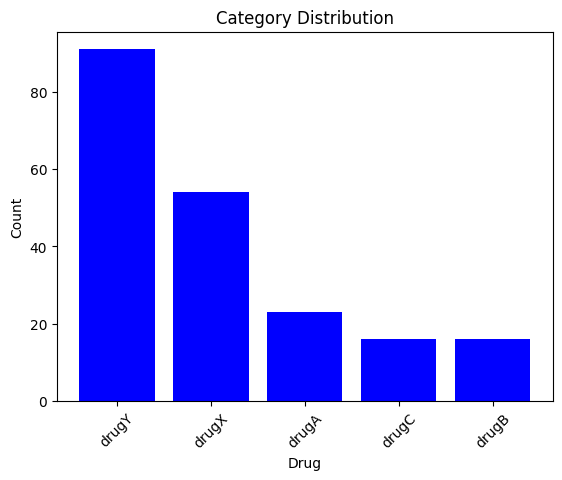

In [9]:
category_counts = my_data['Drug'].value_counts()

# Plot the count plot
plt.bar(category_counts.index, category_counts.values, color='blue')
plt.xlabel('Drug')
plt.ylabel('Count')
plt.title('Category Distribution')
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.show()

Esto nos muestra la distribución de las diferentes clases, indicando claramente que Drug X y Drug Y tienen muchos más registros en comparación con los otros tres.

## Modelado

Para modelar este conjunto de datos con un clasificador de Árbol de Decisión, primero dividimos el conjunto de datos en subconjuntos de entrenamiento y prueba. Para ello, separamos la variable objetivo de las variables de entrada.

In [11]:
y = my_data['Drug']
X = my_data.drop(['Drug','Drug_num'], axis=1)

Ahora, utiliza la función train_test_split() para separar los datos de entrenamiento de los datos de prueba. Podemos usar el 30% de los datos para prueba y el resto para entrenar el Árbol de Decisión.

In [12]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=32)

Ahora puedes definir el clasificador de Árbol de Decisión como drugTree y entrenarlo con los datos de entrenamiento.

In [13]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

In [14]:
drugTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

### Evaluación

Ahora que has entrenado el árbol de decisión, podemos usarlo para generar las predicciones sobre el conjunto de prueba.

In [16]:
tree_predictions = drugTree.predict(X_testset)

Ahora podemos verificar la exactitud (accuracy) de nuestro modelo utilizando la métrica de precisión.

In [17]:
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_testset, tree_predictions))

Decision Trees's Accuracy:  0.9833333333333333


Esto significa que el modelo fue capaz de identificar correctamente las etiquetas en un 98.33%, es decir, 59 de 60 muestras de prueba.

### Visualizar el árbol

Para comprender los criterios de clasificación que ha derivado el Árbol de Decisión, podemos generar un gráfico del árbol.

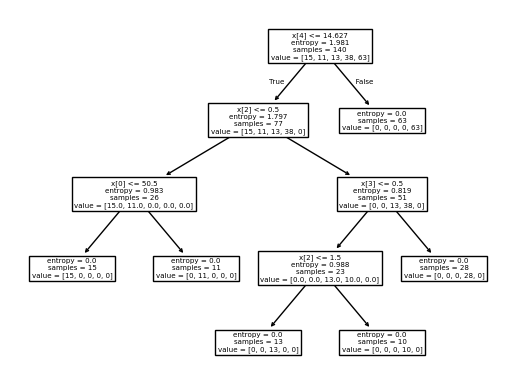

In [18]:
plot_tree(drugTree)
plt.show()

A partir de este árbol, podemos derivar los criterios desarrollados por el modelo para identificar la clase de cada muestra de entrenamiento. Podemos interpretarlos siguiendo los criterios definidos desde la raíz del árbol hasta los nodos hoja.

Por ejemplo, el criterio de decisión para Drug Y es:

𝑁
𝑎
_
𝑡
𝑜
_
𝐾
>
14.627
Na_to_K>14.627

Pregunta de práctica:

De manera similar, identifica los criterios de decisión para todas las demás clases.

Drug A : $Na\_to\_K <= 14.627,\ BP = High,\ Age <= 50.5$<br>
Drug B : $Na\_to\_K <= 14.627,\ BP = High,\ Age > 50.5$<br>
Drug C : $Na\_to\_K <= 14.627,\ BP = Low,\ Cholesterol <= High$<br>
Drug X : $Na\_to\_K <= 14.627,\ BP = Normal,\ Cholesterol = High$

Pregunta de práctica:

Si se reduce la profundidad máxima del árbol a 3, ¿cómo se vería afectado el rendimiento del modelo?

In [19]:
drugTree = DecisionTreeClassifier(criterion="entropy", max_depth = 3)
drugTree.fit(X_trainset,y_trainset)
tree_predictions = drugTree.predict(X_testset)
print("Decision Trees's Accuracy: ", metrics.accuracy_score(y_testset, tree_predictions))

Decision Trees's Accuracy:  0.8166666666666667


Final del cuadernillo